# POD and fft from pointclouds 

We will now proceed to explain how to perform POD from point clouds. In this instance, we test only for POD in serial, as to perform in parallel, a parallel reader/writer is needed.

If you have saved information in hdf5 and have habilitated mpi4py compilation of it, then you could use this code in parallel.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys

# Get mpi info
comm = MPI.COMM_WORLD

## Set up the input parameters

In [2]:
file_sequence = [f"interpolated_fields{str(1+i).zfill(5)}.hdf5" for i in range(0, 48)]
file_sequence = [f"interpolated_fields{str(1+i).zfill(5)}.hdf5" for i in range(0, 1)]
pod_fields = ["u", "v", "w"]
mesh_fname = "points.hdf5"
mass_matrix_fname = "points.hdf5"
mass_matrix_key = "mass_area"
mass_matrix_key = "mass"
k = len(file_sequence)
p = len(file_sequence)
fft_axis = 1 # 0 for x, 1 for y, 2 for z

# Calculated parameters
number_of_pod_fields = len(pod_fields)

## Call the pynektools routines

In [3]:
def get_wavenumber_slice(kappa, fft_axis):
    if fft_axis == 0:
        return (kappa, slice(None), slice(None))
    elif fft_axis == 1:
        return (slice(None), kappa, slice(None))
    elif fft_axis == 2:
        return (slice(None), slice(None), kappa)

# Import IO helper functions
from pynektools.io.utils import get_fld_from_ndarray

# Import types asociated with POD
from pynektools.rom.pod import POD
from pynektools.rom.io_help import IoHelp

# Output
from pyevtk.hl import gridToVTK

# Load the mesh
with h5py.File(mesh_fname, 'r') as f:
    x = f["x"][:]
    y = f["y"][:]
    z = f["z"][:]

# Load the mass matrix
with h5py.File(mass_matrix_fname, 'r') as f:
    bm = f[mass_matrix_key][:]
bm[np.where(bm == 0)] = 1e-8
_3d_bm_shape = bm.shape
print(_3d_bm_shape)

# Have a slice of the axis to perform the fft
if fft_axis == 0:
    mass_slice = (0, slice(None), slice(None))
elif fft_axis == 1:
    mass_slice = (slice(None), 0, slice(None))
elif fft_axis == 2:
    mass_slice = (slice(None), slice(None), 0)

# Obtain the number of frequencies you will obtain
N_samples = bm.shape[fft_axis]
number_of_frequencies = N_samples // 2 + 1

# Choose the proper mass matrix slice
bm = bm[mass_slice]
#bm = np.sum(bm, axis = fft_axis)
#bm = bm/_3d_bm_shape[fft_axis]


ioh = {"wavenumber" : "buffers"}
pod = {"wavenumber" : "POD object"}

# Initialize the buffers and objects for each wavenumber
for kappa in range(0, number_of_frequencies):

    # Instance io helper that will serve as buffer for the snapshots
    ioh[kappa] = IoHelp(comm, number_of_fields = number_of_pod_fields, batch_size = p, field_size = bm.size, mass_matrix_data_type=bm.dtype, field_data_type=np.complex128,  module_name="buffer_kappa"+str(kappa))

    # Put the mass matrix in the appropiate format (long 1d array)
    mass_list = []
    for i in range(0, number_of_pod_fields):
        mass_list.append(np.copy(np.sqrt(bm)))
    ioh[kappa].copy_fieldlist_to_xi(mass_list)
    ioh[kappa].bm1sqrt[:,:] = np.copy(ioh[kappa].xi[:,:])

    # Instance the POD object
    pod[kappa] = POD(comm, number_of_modes_to_update = k, global_updates = True, auto_expand = False)

# Perform reading and updates
j = 0
while j < len(file_sequence):

    # Load the snapshot data
    fname = file_sequence[j]
    with h5py.File(fname, 'r') as f:
        fld_data = []
        for field in pod_fields:
            fld_data.append(f[field][:])
        
        import copy
        fld_data_copy = copy.deepcopy(fld_data)

    # Perform the fft
    for i in range(0, number_of_pod_fields):
        fld_data[i] = np.fft.fft(fld_data[i], axis = fft_axis)/(N_samples)

    # For each wavenumber, put the snapshot data into the buffer    
    for kappa in range(0, number_of_frequencies):

        # Decide if I should double the energy in this snapshot
        if kappa == 0:
            multiplier = 1 
        else:
            multiplier = 2

        # Get the proper slice for the wavenumber
        positive_wavenumber_slice = get_wavenumber_slice(kappa, fft_axis)

        # Get the wavenumber data
        wavenumber_data = []
        for i in range(0, number_of_pod_fields):
            wavenumber_data.append(fld_data[i][positive_wavenumber_slice]*multiplier)

        # Put the snapshot data into a column array
        ioh[kappa].copy_fieldlist_to_xi(wavenumber_data)

        # Load the column array into the buffer
        ioh[kappa].load_buffer(scale_snapshot = True)
        
        # Update POD modes
        if ioh[kappa].update_from_buffer:
            pod[kappa].update(comm, buff = ioh[kappa].buff[:,:(ioh[kappa].buffer_index)])


    j += 1

    print("Times entered" + str(j))
    print("Times entered" + str(j))
    print("Times entered" + str(j))

for kappa in range(0, number_of_frequencies):
    # Check if there is information in the buffer that should be taken in case the loop exit without flushing
    if ioh[kappa].buffer_index > ioh[kappa].buffer_max_index:
        ioh[kappa].log.write("info","All snapshots where properly included in the updates")
    else: 
        ioh[kappa].log.write("warning","Last loaded snapshot to buffer was: "+repr(ioh[kappa].buffer_index-1))
        ioh[kappa].log.write("warning","The buffer updates when it is full to position: "+repr(ioh[kappa].buffer_max_index))
        ioh[kappa].log.write("warning","Data must be updated now to not lose anything,  Performing an update with data in buffer ")
        pod[kappa].update(comm, buff = ioh[kappa].buff[:,:(ioh[kappa].buffer_index)])

    # Scale back the modes
    pod[kappa].scale_modes(comm, bm1sqrt = ioh[kappa].bm1sqrt, op = "div")

    # Rotate local modes back to global, This only enters in effect if global_update = false
    pod[kappa].rotate_local_modes_to_global(comm)

# Write the data in vtk for now
# Go over the modes

for kappa in range(0, number_of_frequencies):

    if kappa == 0:
        multiplier = 1
    else:
        multiplier = 2

    for j in range(0, k):
        
        ## Split the 1d snapshot into a list with the fields you want
        field_list1d = ioh[kappa].split_narray_to_1dfields(pod[kappa].u_1t[:,j])
        ## Reshape the obtained 1d fields to be 2d
        field_list_2d = [field.reshape(bm.shape) for field in field_list1d]
        
        field_dict = {}
        positive_wavenumber_slice = get_wavenumber_slice(kappa, fft_axis)
        negative_wavenumber_slice = get_wavenumber_slice(-kappa, fft_axis)
        for i in range(0, len(pod_fields)):
        
            # Create a buffer to zero out all the other wavenumber contributions
            fourier_field_3d = np.zeros(_3d_bm_shape, dtype=pod[kappa].u_1t.dtype)
        
            # Fill the buffer with the proper wavenumber contribution
            fourier_field_3d[positive_wavenumber_slice] = field_list_2d[i]
            if kappa != 0:
                fourier_field_3d[negative_wavenumber_slice] = np.conj(field_list_2d[i])

            # Perform the inverse fft
            physical_field_3d = np.fft.ifft(fourier_field_3d*N_samples/multiplier, axis = fft_axis) # Rescale the coefficients
            
            # Save the field in the dictionary later used to write the vtk
            field_dict[f"{pod_fields[i]}_mode"] = np.copy(physical_field_3d.real)

        # write to vtk
        gridToVTK( f"kappa{kappa}_pod_mode"+str(j).zfill(5),  x, y, z, pointData=field_dict)

(30, 30, 80)
2024-09-23 15:40:48,898 - buffer_kappa0 - INFO - io_helper object initialized
2024-09-23 15:40:48,899 - pod - WARNING - ifget_all_modes is hard coded to False. This parameter applies to lcl updates. It controls if one gets all modes in the global rotation, despite keeping less modes locally. I do not see a use for this in production runs. Thus it is set to false. If needed, activate in mpi_spSVD.py module
2024-09-23 15:40:48,899 - pod - INFO - POD Object initialized
2024-09-23 15:40:48,900 - buffer_kappa1 - INFO - io_helper object initialized
2024-09-23 15:40:48,901 - pod - WARNING - ifget_all_modes is hard coded to False. This parameter applies to lcl updates. It controls if one gets all modes in the global rotation, despite keeping less modes locally. I do not see a use for this in production runs. Thus it is set to false. If needed, activate in mpi_spSVD.py module
2024-09-23 15:40:48,902 - pod - INFO - POD Object initialized
2024-09-23 15:40:48,903 - buffer_kappa2 - INF

/tmp/ipykernel_22134/2012981929.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  ioh[kappa].bm1sqrt[:,:] = np.copy(ioh[kappa].xi[:,:])


# Check the reconstruction

In [4]:
# Check that the FFT and IFFT produce the right results
for i in range(0, number_of_pod_fields):
    print(np.allclose(fld_data[i], np.fft.fft(fld_data_copy[i], axis = fft_axis)/(N_samples)))

for i in range(0, number_of_pod_fields):
    print(np.allclose(fld_data_copy[i], np.fft.ifft(fld_data[i] * N_samples, axis = fft_axis)))

True
True
True
True
True
True


In [5]:
# Verify that per wavenumber, the results are reconstructed properly
# Everything should return as true

# Create buffer to contain the full fourier fields
fourier_field_3d = [np.zeros(_3d_bm_shape, dtype=pod[0].u_1t.dtype) for i in range(0, number_of_pod_fields)]

freqs = [kappa for kappa in range(0, number_of_frequencies)]
for kappa in freqs:

    multiplier = 2 if kappa != 0 else 1

    positive_wavenumber_slice = get_wavenumber_slice(kappa, fft_axis)
    negative_wavenumber_slice = get_wavenumber_slice(-kappa, fft_axis)
    print(positive_wavenumber_slice)

    pod_modes = pod[kappa].u_1t
    pod_sigma = pod[kappa].d_1t
    pod_vt = pod[kappa].vt_1t

    pod_reconst = pod_modes@np.diag(pod_sigma)@pod_vt

    ## Split the 1d snapshot into a list with the fields you want
    field_list1d = ioh[kappa].split_narray_to_1dfields(pod_reconst)
    ## Reshape the obtained 1d fields to be 2d
    field_list_2d = [field.reshape(bm.shape) for field in field_list1d]

    for i in range(0, number_of_pod_fields):

        fld_hat = fld_data[i][positive_wavenumber_slice]
        fld_reconst = field_list_2d[i]
        print(np.allclose(fld_hat, fld_reconst/multiplier))

        fourier_field_3d[i][positive_wavenumber_slice] = fld_reconst/multiplier
        if kappa != 0:
            fourier_field_3d[i][negative_wavenumber_slice] = np.conj(fld_reconst)/multiplier

# Check that my reconstructed fourier field matches the data
for i in range(0, number_of_pod_fields):
    print(np.allclose(fourier_field_3d[i], fld_data[i]))

# now check that the reconstructed physical field matches the data
physical_field_3d = np.zeros(_3d_bm_shape)
for i in range(0, number_of_pod_fields):

    physical_field_3d = np.fft.ifft(fourier_field_3d[i]*N_samples, axis = fft_axis).real
    print(np.allclose(physical_field_3d, fld_data_copy[i]))


(slice(None, None, None), 0, slice(None, None, None))
True
True
True
(slice(None, None, None), 1, slice(None, None, None))
True
True
True
(slice(None, None, None), 2, slice(None, None, None))
True
True
True
(slice(None, None, None), 3, slice(None, None, None))
True
True
True
(slice(None, None, None), 4, slice(None, None, None))
True
True
True
(slice(None, None, None), 5, slice(None, None, None))
True
True
True
(slice(None, None, None), 6, slice(None, None, None))
True
True
True
(slice(None, None, None), 7, slice(None, None, None))
True
True
True
(slice(None, None, None), 8, slice(None, None, None))
True
True
True
(slice(None, None, None), 9, slice(None, None, None))
True
True
True
(slice(None, None, None), 10, slice(None, None, None))
True
True
True
(slice(None, None, None), 11, slice(None, None, None))
True
True
True
(slice(None, None, None), 12, slice(None, None, None))
True
True
True
(slice(None, None, None), 13, slice(None, None, None))
True
True
True
(slice(None, None, None), 14, 

## Check the energy

In [6]:
u_ = fld_data_copy[0]
v_ = fld_data_copy[1]
w_ = fld_data_copy[2]


# Get the energy
with h5py.File(mass_matrix_fname, 'r') as f:
    bm_v = f["mass"][:]

print(bm_v.shape)
print(np.sum(bm_v))
print(bm.shape)
print(np.sum(bm))

e_ = np.sum((u_**2 + v_**2 + w_**2)*bm_v)/2
e_ = np.sum((u_**2 + v_**2 + w_**2)*bm_v)
print(f"Energy from snapshots {e_}")

# Get the energy
e_pod = 0
for kappa in range(0, number_of_frequencies):
    e_pod += np.sum((pod[kappa].d_1t))
    #print(pod[kappa].d_1t)

#print(pod[0].u_1t.dtype)
#print(pod[0].d_1t.dtype)
#print(pod[0].vt_1t.dtype)

print(f"Energy from POD {e_pod}")
print(f"Energy from POD {e_pod**2}")
print(f"Energy from POD {np.sqrt(e_pod)}")

print("=====================================")

e_pod = 0
for kappa in range(0, number_of_frequencies):
    e_pod += np.sum((pod[kappa].d_1t)**2)

print(f"Energy from POD {e_pod}")
print(f"Energy from POD {e_pod**2}")
print(f"Energy from POD {np.sqrt(e_pod)}")


print(np.sum(bm_v))
print(np.sum(bm))

(30, 30, 80)
0.007853981633974483
(30, 80)
0.00013621347644783593
Energy from snapshots 3.7133989877904314e-05
Energy from POD 0.00251254216579582
Energy from POD 6.312868134901951e-06
Energy from POD 0.05012526474539382
Energy from POD 1.1721827652867368e-06
Energy from POD 1.374012435235261e-12
Energy from POD 0.0010826738960955588
0.007853981633974483
0.00013621347644783593


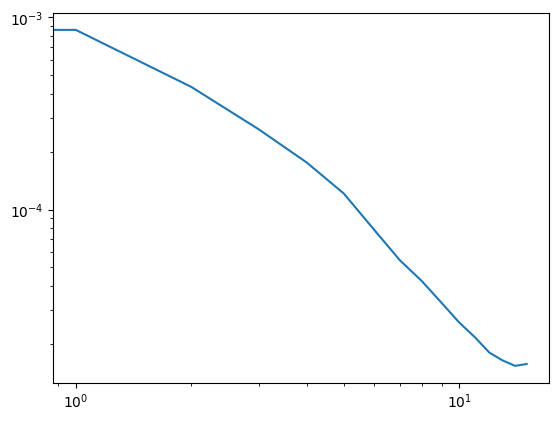

In [7]:
temp = []
for kappa in range(0, number_of_frequencies):
    temp.append(pod[kappa].d_1t[0])

plt.plot(temp)
plt.yscale("log")
plt.xscale("log")
plt.show()